# Squid Simulation Project
MAM3041H</br>
Connor Goosen</br>
***
## Introduction
This is a single Jupyter notebook that will hopefully be able to house the entirety of this project. The project's main goal as I understand it is to simulate a population of squid that breeds once each year (cycle) and is then fished. Over the rest of the year the squid are hunted by natural preditors which brings their population down untill the next breeding event.

Our goal is to find the funciton that minimises the variance of the year on year yield, while maximising profits and ensuring sustainable levels for the squid populaiton.
My first goal however is to build the enviroment in which to test these functions.

If the biomass of the squid present at the start of year $t$ is $B_{t}$, then the dynamics of the squid population is given by:

$$B_{t+1} = [B_t + R(B_t)-C_t]e^{-M}$$

Where 

$R(B_t) =\frac{\alpha B_t}{\beta + B_t} $ is the recruitment in year t, and<br>
$C_t$ is the catich taken in year t, and<br>
$M$ is the instantaneous rate of natural mortality.

## Analytical Solutions

### Finding Carrying Capacity of the Squid:
let $C_t = 0$
$$B_{t+1} = [B_t + \frac{\alpha B_t}{\beta + B_t}]e^{-M}$$
The point of stability in the update equation occurs when $B_{t+1} = B_t$. Therefore <br>
$$B_{t} = [B_t + \frac{\alpha B_t}{\beta + B_t}]e^{-M}$$
Solving for $B_t$ gives us:<br>
$$B_{t} = \frac{\alpha}{e^M - 1} - \beta$$
We can define this expression as the carrying capacity for the population of squid:<br>
$$K:=\frac{\alpha}{e^M - 1} - \beta$$

### Finding $\beta$
We are given that if the recruitment is $R(K)$, then the gradient of the slope is:
$$R(0.2K) = hR(K)$$
<br>
$$R(0.2K) = \frac{\alpha(0.2K)}{\beta + 0.2K} = hR(K)$$
Solving this for $\beta$ will give:
$$\beta = \frac{0.2K(1-h)}{h-0.2}$$

## Practical Example

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import statistics as stats
from math import nan
%config InlineBackend.figure_format ='retina' #Increases resolution of plots

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) #Getting depreciatoin warnings for my normal distribution arrays...


t = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
c_test = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [2]:
k = 1000000
h = 0.7
M = 1
Be = (0.2 * k *(1-h))/(h-0.2)
a = (k+Be)*( (np.e**M) -1)
def R(B):
    return a*B/(Be+B)

def Ct(Bt, Bto): #Bto is Bt+1 
    return Bt + R(Bt) - np.e**M*Bto 

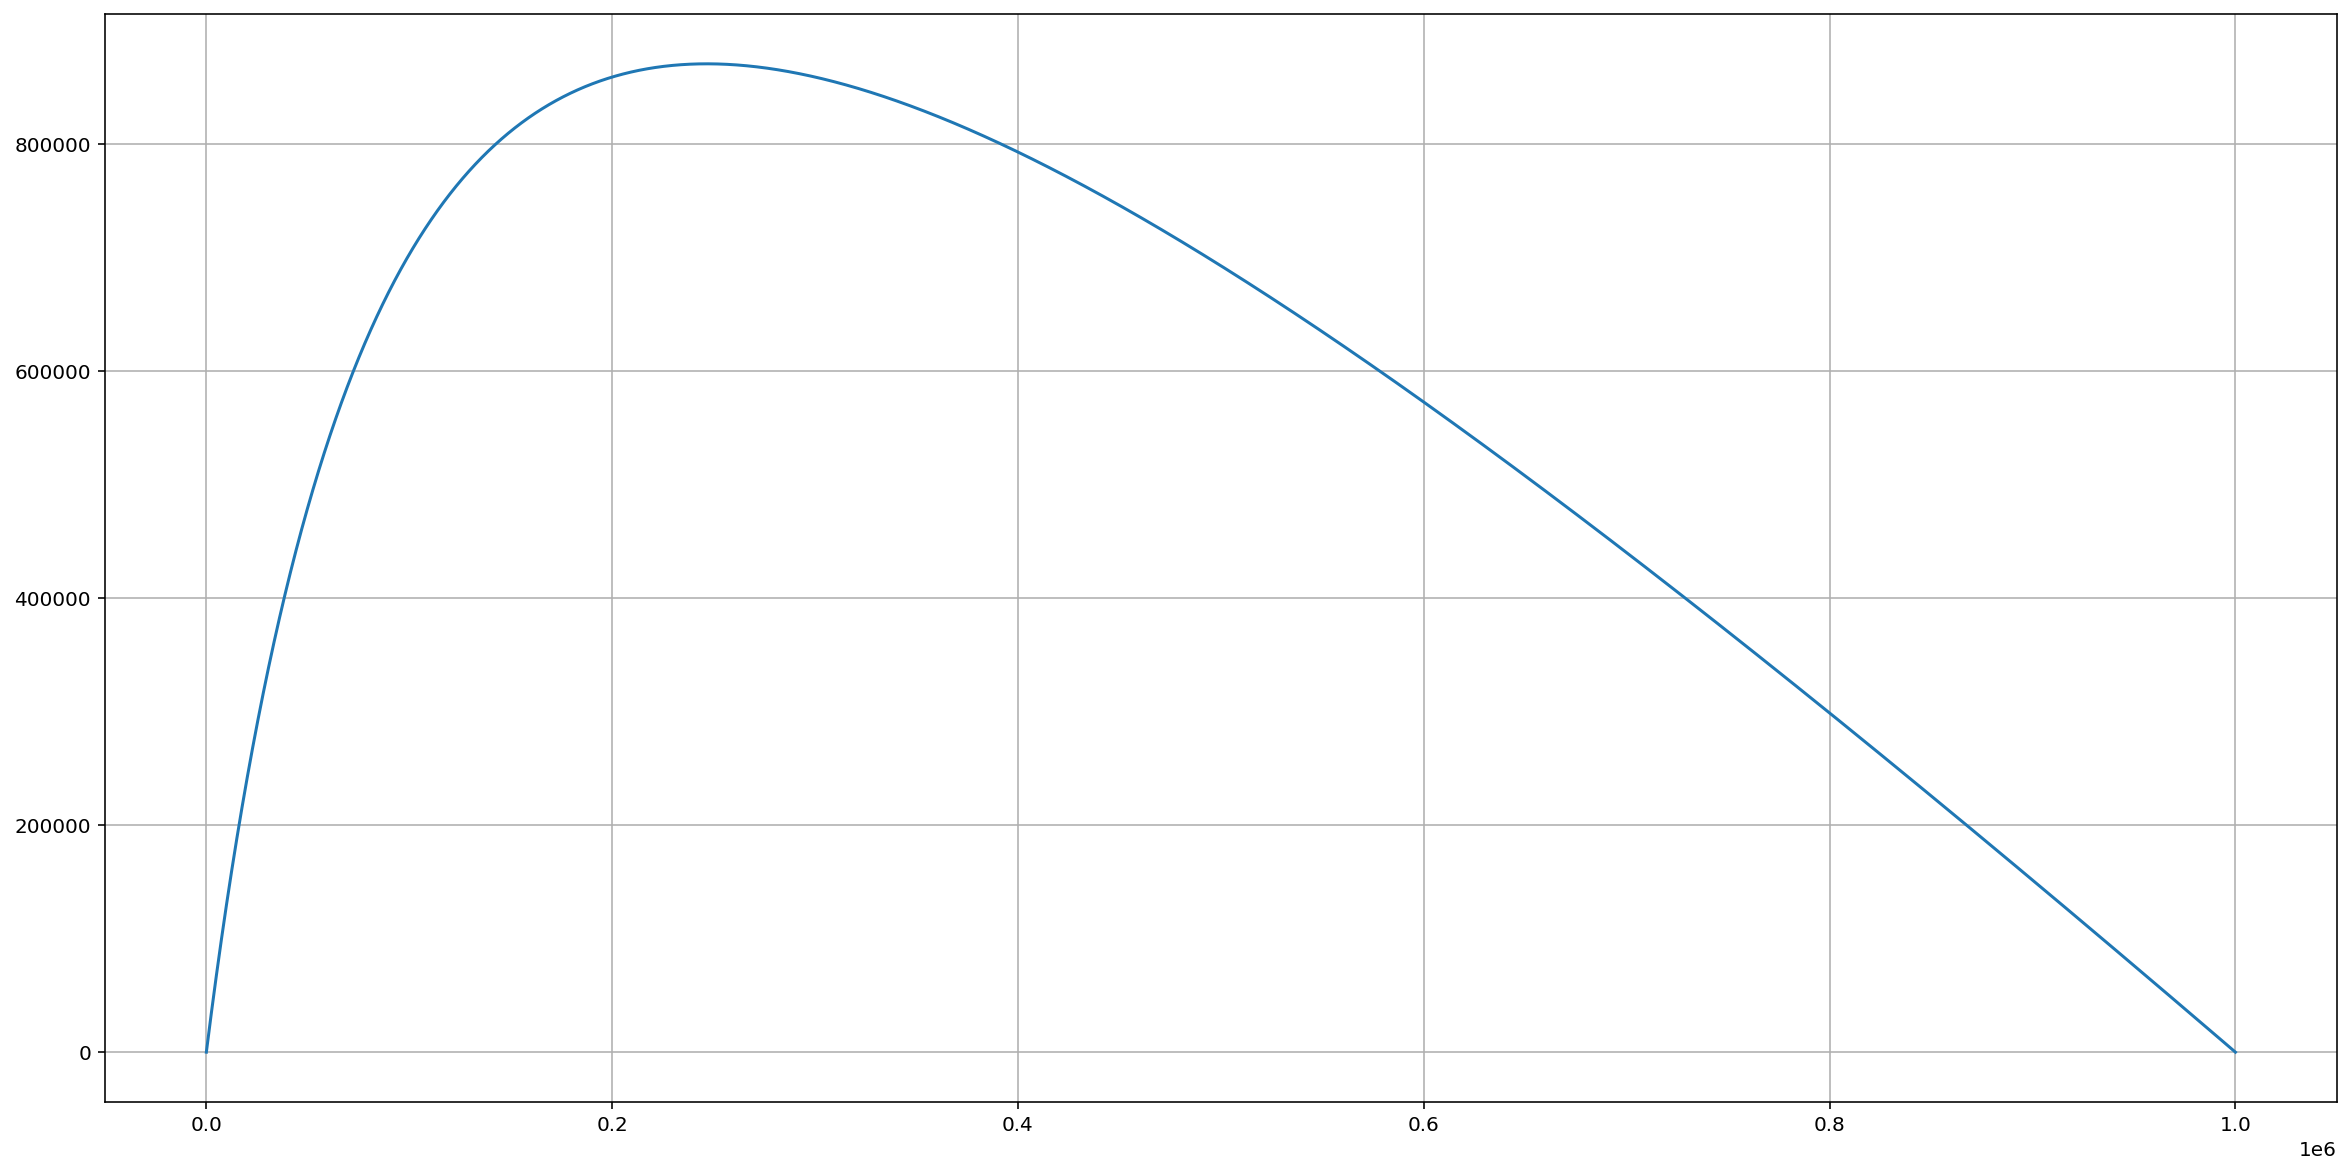

In [3]:

BT = np.linspace(0, 1000000, 1000000)
CT = np.zeros(1000000)

for i in range(0, len(BT)-1):
    CT[i] = Ct(BT[i], BT[i+1])

plt.figure(figsize = (20, 10))
plt.plot(BT, CT)
plt.grid()

## Squid Simulation Enviroment

I now need to set up the simulation enviroment to allow multiple $C_t$ funcitons to be 'run' in the enviroment to test their effectivness

In [4]:
def et(sigR): #Recruitment Variation
    return np.random.normal(0, sigR)

def nt(sigS): #Error in biomass observation
    return np.random.normal(0, sigS) 

def a(k, M, Be): #Returns the value of alpha
    return (k+Be)*( (np.e**M)-1 )

def b(h, k):#Returns Value of beta
    return (0.2*k*(1-h)) / (h - 0.2)

def Ru(B, a, Be, sigR, recruit_toggle): #Recruitment Function
    if recruit_toggle == True:
        r = ((a*B)/(Be+B)) * np.e**(et(sigR) - ((sigR**2)/2))
    else:
        r = (a*B)/(Be+B)
    return r

In [5]:
def squidcycle(C, recruit_toggle, obs_toggle):
    """
    squid cycle takes an initial biomass, and the other parameters detailed below, and runs a 20 year simulation
    whereby the squid have a recruitment period, have a catching season, and remain to be hunted by it's natural preditors
    until the next recruitment period.
    
    Bi is the initial biomass.
    sigR is the standard deviation for the normal distribution that takes the variation in recruitment into account.
    sigS is the standard deviation for the normal distribution that takes the error in survey observation into account.
    K is the Carrying Capacity of the system.
    be is beta.
    al is alpha
    M is the mortality rate of the squid due to natural processes.
    C is the catch function.
    recruit_toggle toggles the presense of random variation in the recruitment.
    obs_toggle toggles the presense of random error of observation.
    
    The function returns an array of the biomass at each time step.
    """
    #Inital Conditions
    Bi = 1
    K = 1
    sigR = 0.3
    sigS = 0.2
    h = 0.7
    be = (0.2*K*(1-h)) / (h - 0.2)
    M = 1
    al = (K+be)*( (np.e**M)-1 )
    #Simulation Setup
    Barr = np.zeros(len(t))
    
    #Alternate implimentations based on whether we want random effects. This part applies to the first observation
    if obs_toggle == True:
        Bobs = Bi*np.e**( nt(sigS) - ((sigS**2)/2) )
    else:
        Bobs = Bi
    
    for i in range(0, len(t)):
        Barr[i] = Bobs
        if Barr[i] <=0: #This stops the simulation from running if the population has dropped to (or below) zero. The species is extinct.
            break
        else:
            tmpy = Bobs
            Bobs = (tmpy + Ru(tmpy, al, be, sigR, recruit_toggle) - C) * np.e**(-M)
            if obs_toggle == True:
                Bobs = Bobs*np.e**( nt(sigS) - ((sigS**2)/2) ) #Adds random variation to the observation.
    return Barr

### Test defined catch functions

This is our catch function that allows us to compare our simulations to ensure consistancy before we start developing our own catch algorithms:

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

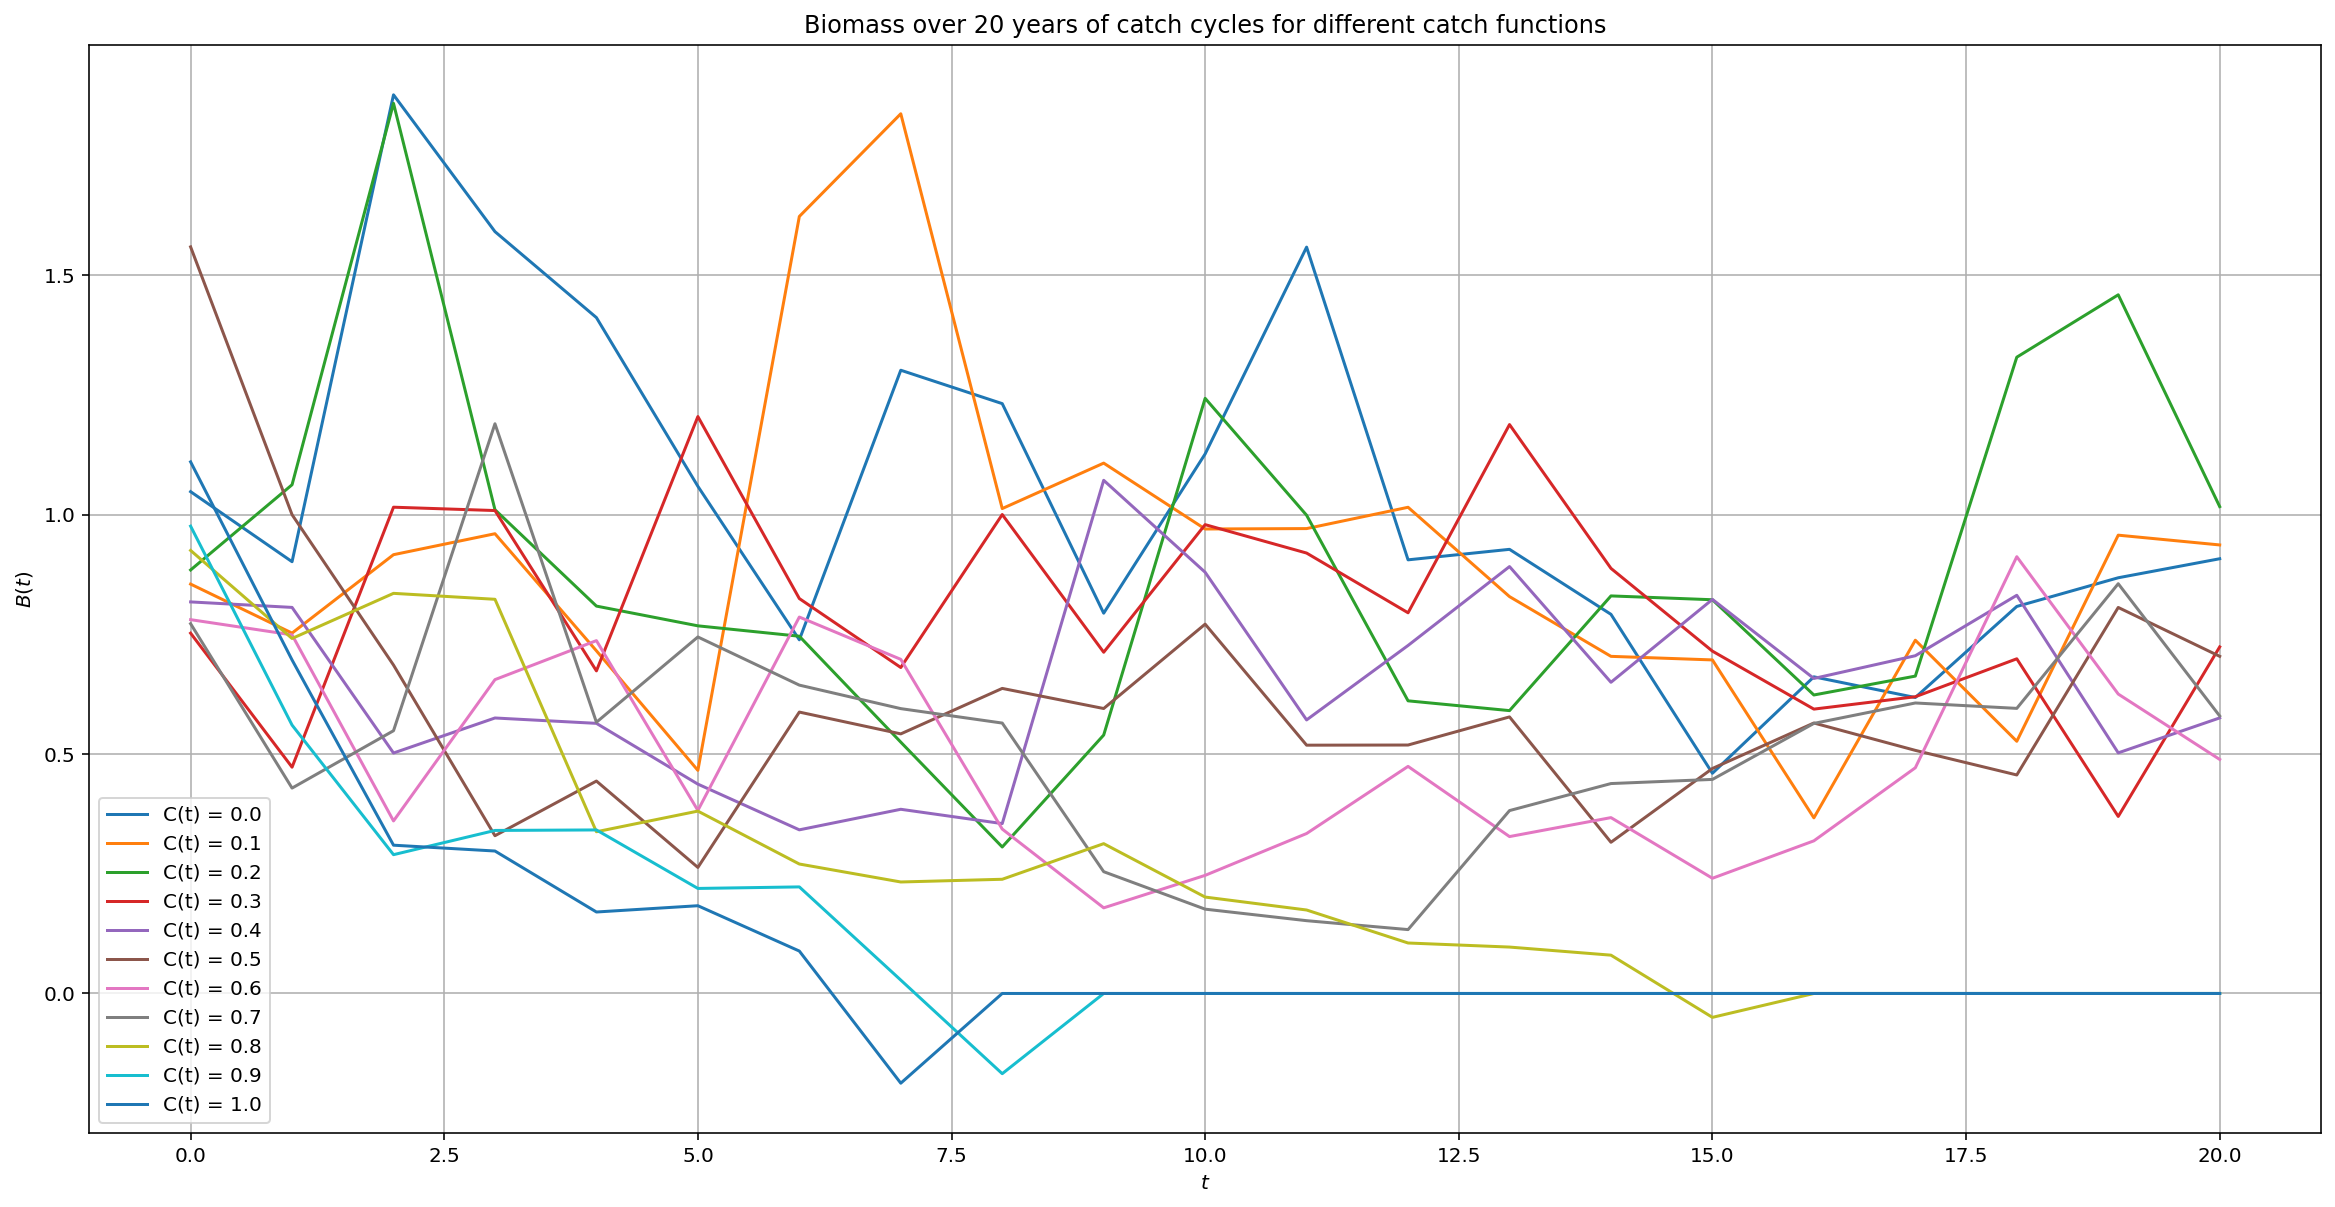

In [6]:
b_all = [] #This will store 10 20-year simulations (10X20 element 2d array)
b_end = [] # This will store the final biomass from all 10 simulations (10 element array)
for i in range(0, len(c_test), 1):
    b_all.append( squidcycle(c_test[i], True, True) )
    b_end.append(b_all[i][-1])
    
    plt.figure(figsize = (20,10))
for i in range(0, len(b_all), 1):
    plt.plot(t, b_all[i], label = "C(t) = "+str(c_test[i]))
plt.grid()
plt.title("Biomass over 20 years of catch cycles for different catch functions")
plt.ylabel(r"$B(t)$")
plt.xlabel(r"$t$")
plt.legend()

We can plot the final points of each of these simulations with the `b_end` array.

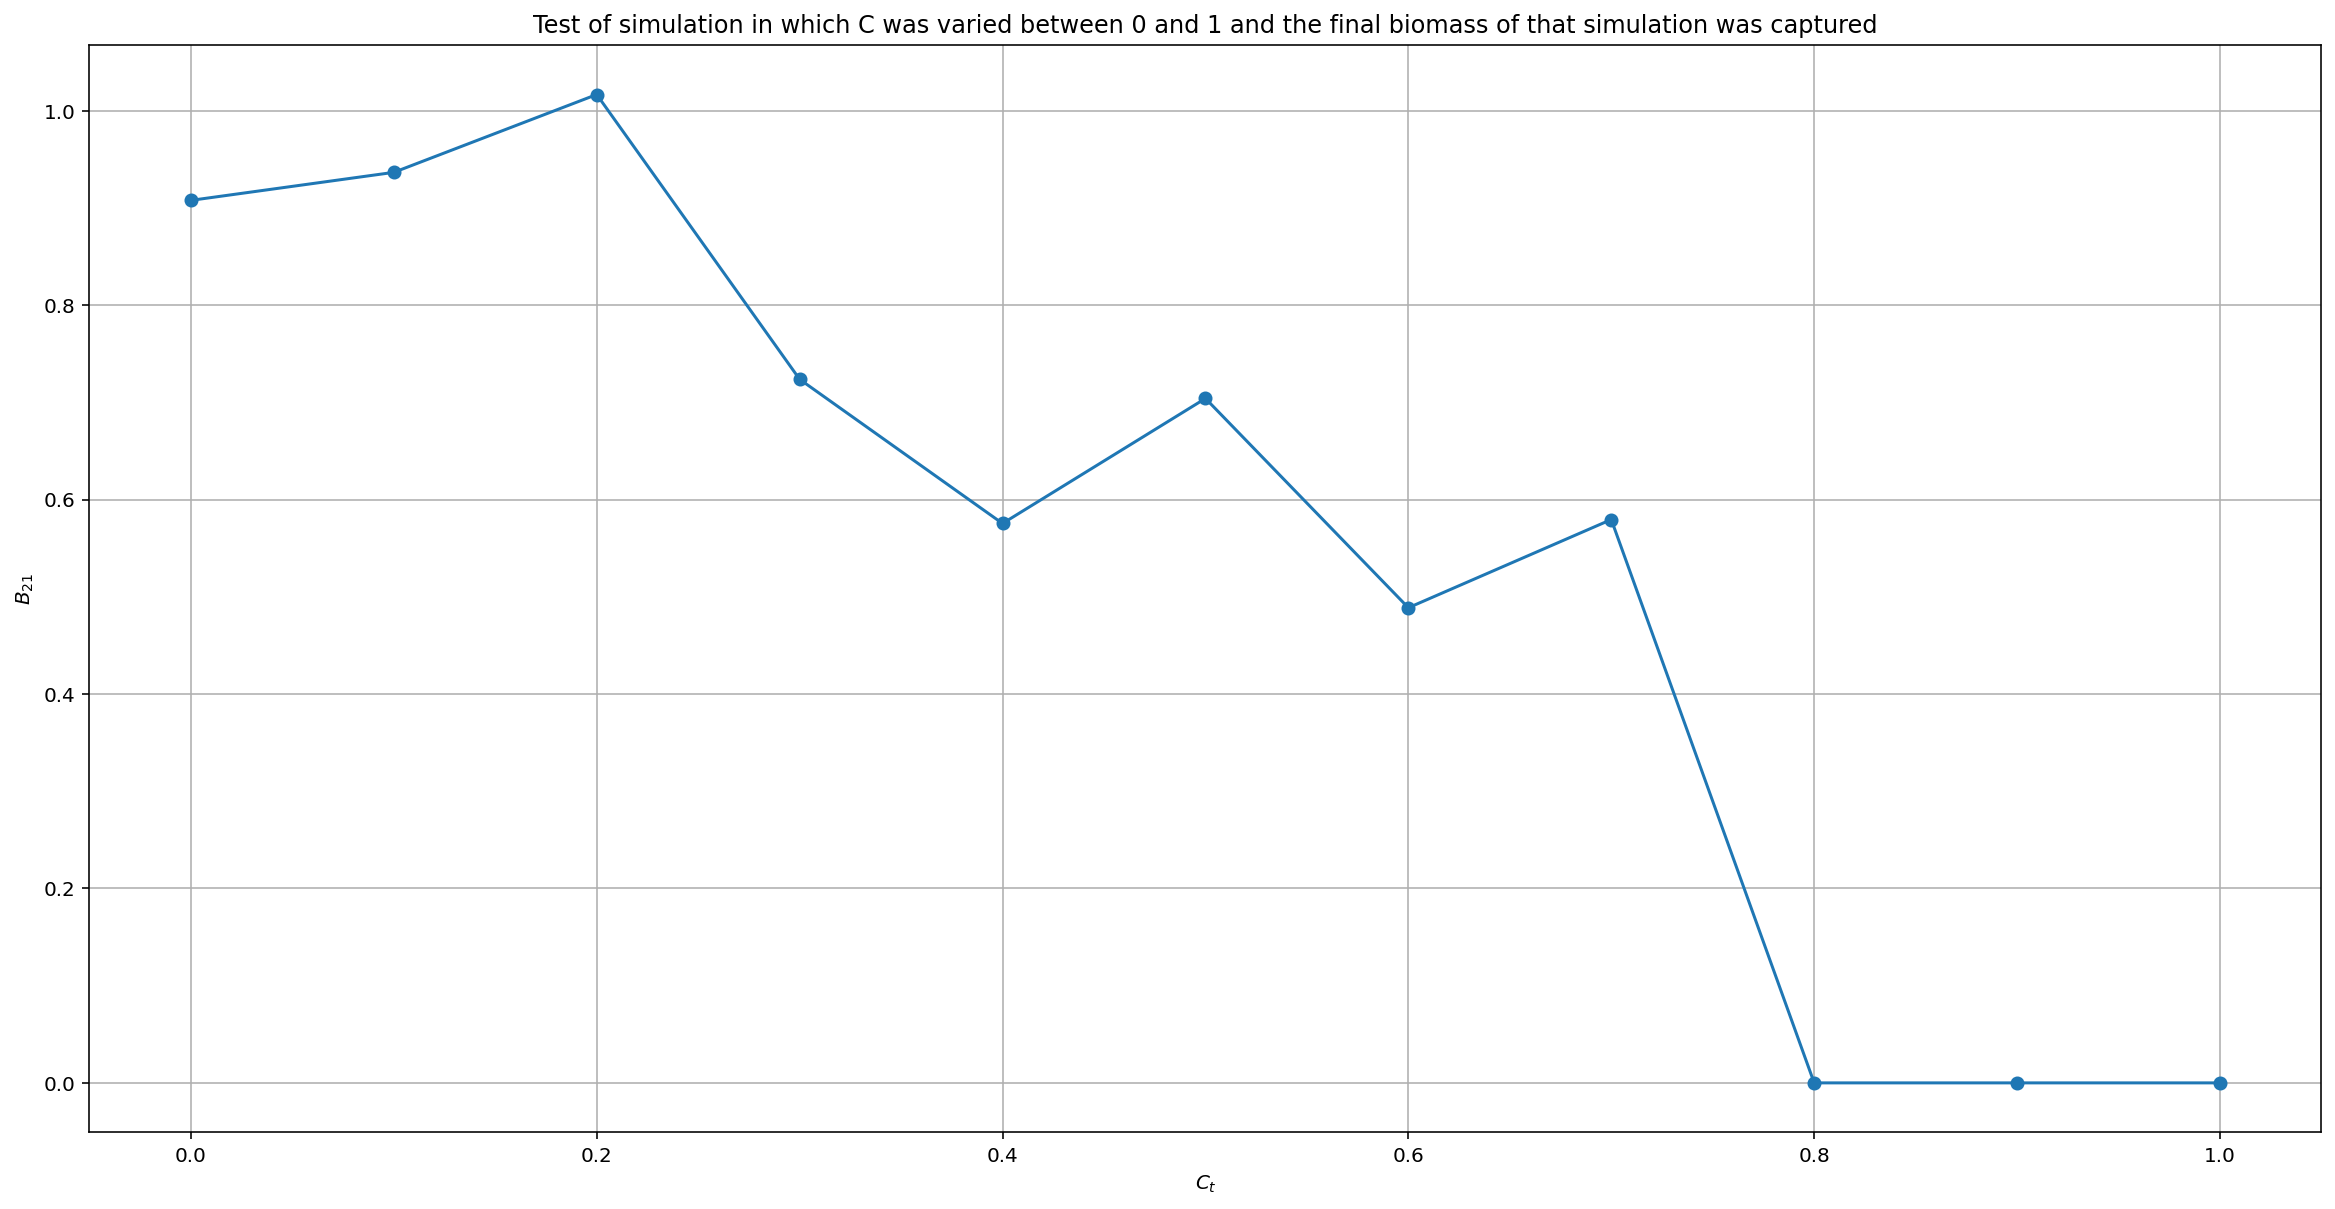

In [7]:
plt.figure(figsize = (20,10))
plt.plot(c_test, b_end, marker = 'o', linestyle = None)
plt.title("Test of simulation in which C was varied between 0 and 1 and the final biomass of that simulation was captured")
plt.ylabel(r"$B_{21}$")
plt.xlabel(r"$C_t$")
plt.grid()

In [8]:
df_endBiomass = pd.DataFrame({'Catch Function': c_test, r'$B_{21}$':b_end})
display(df_endBiomass)

,Catch Function,$B_{21}$
0,0.0,0.907808
1,0.1,0.936620
2,0.2,1.016682
3,0.3,0.723751
4,0.4,0.575435
5,0.5,0.704061
6,0.6,0.488750
7,0.7,0.579491
8,0.8,0.000000
9,0.9,0.000000


So this is a 'working' (to be detirmined) run of the first part of the simulation project. The issue here is that with the random variation I won't get consistant results if I run the same code twice. So we need to set the random variation to be consistant for three reasons:
 - Every simulation in the plot is being compared to each other despite having different random variations (this isn't really an issue as it'll be the same later)
 - Each time an individual runs this code they'll get slightly different results
 - Therefore if several people run it once and compare code, they'll naturally get different results.</br>

Alternatively we can take the random components out by adding a toggle to ```squid_cycle(c, random_toggle)``` and setting up a method around the code above to easily run multiple instances of the simulation. we can toggle the random effects out making each simulation fully detirministic.

NOTE: This has been since updated to: ```squid_cycle(c, recruit_toggle, obs_toggle)``` to allow independant control of the two random effects in the simulation. 

### Ensuring reproducability

In [94]:
def twenty_year_simulation(C, recruit_toggle, obs_toggle): #This allows you to simply imput whether you want to take random effects into account.
    b_all = []
    for i in range(0, len(c_test), 1):
        b_all.append(squidcycle(c_test[i], recruit_toggle, obs_toggle))
    
    plt.figure(figsize = (20,10))
    for i in range(0, len(b_all), 1):
        plt.plot(t, b_all[i], label = "C(t) = "+str(c_test[i]))
    plt.grid()
    plt.title("Biomass over 20 years of catch cycles for different catch functions")
    plt.ylabel(r"$B(t)$")
    plt.xlabel(r"$t$")
    plt.legend()
    ax = plt.axes()
    ax.set_facecolor('#eaeaf2')
    plt.savefig("20year.jpeg")

This method should allow me to easily toggle any random effects which could make it easier for us to compare results?

### Simulation with random effects:

<ipython-input-94-42bb79ee591f>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


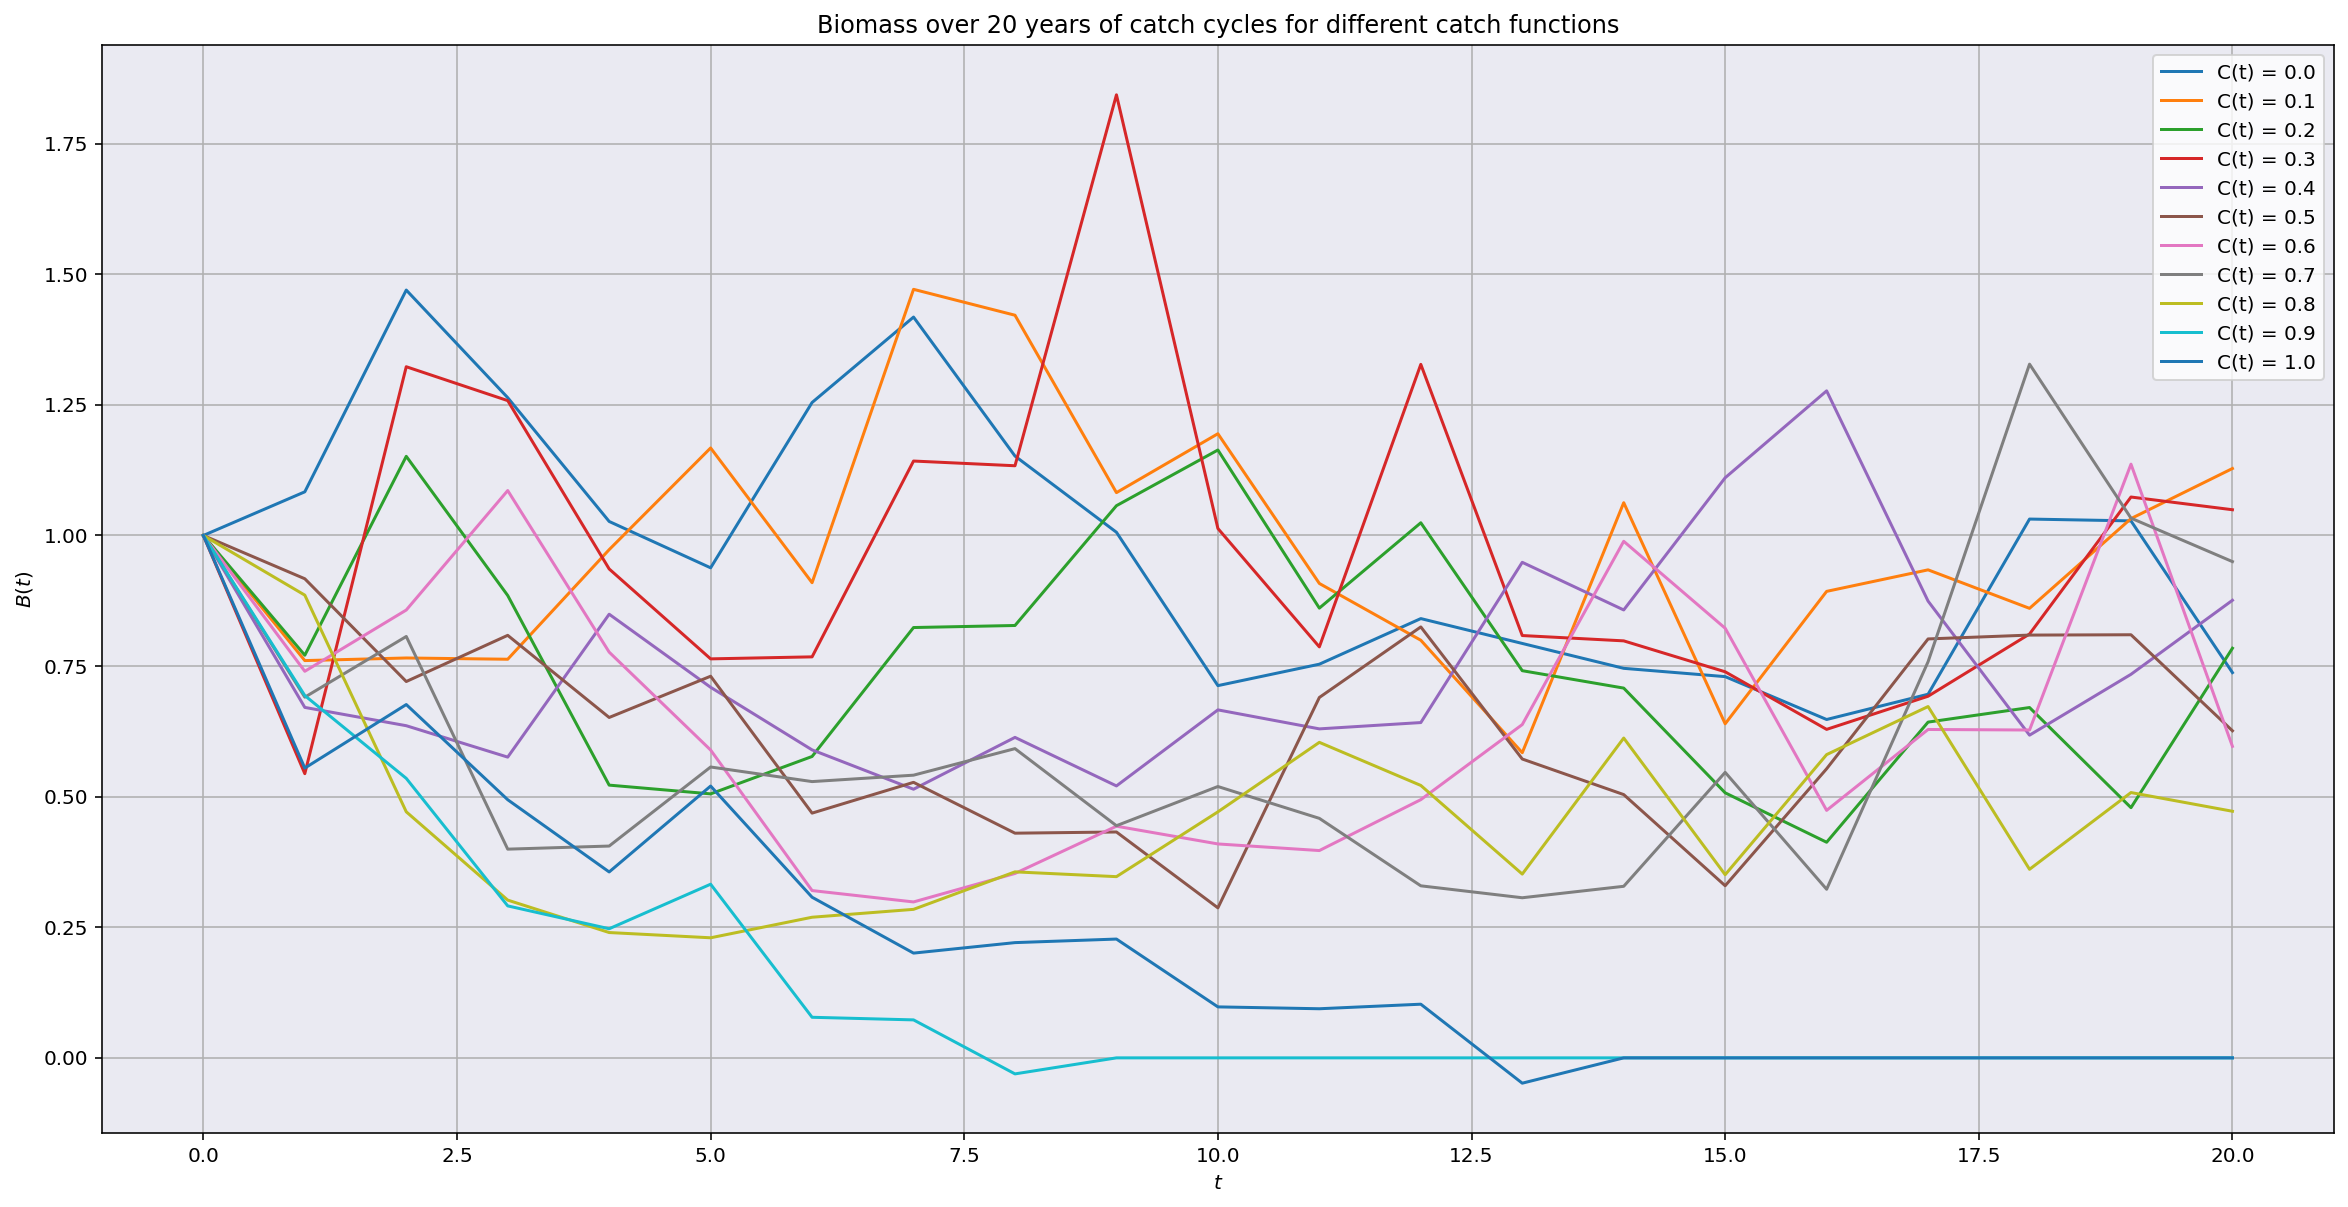

In [95]:
twenty_year_simulation(c_test, True, False)

### Simulation without random effects:

<ipython-input-94-42bb79ee591f>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


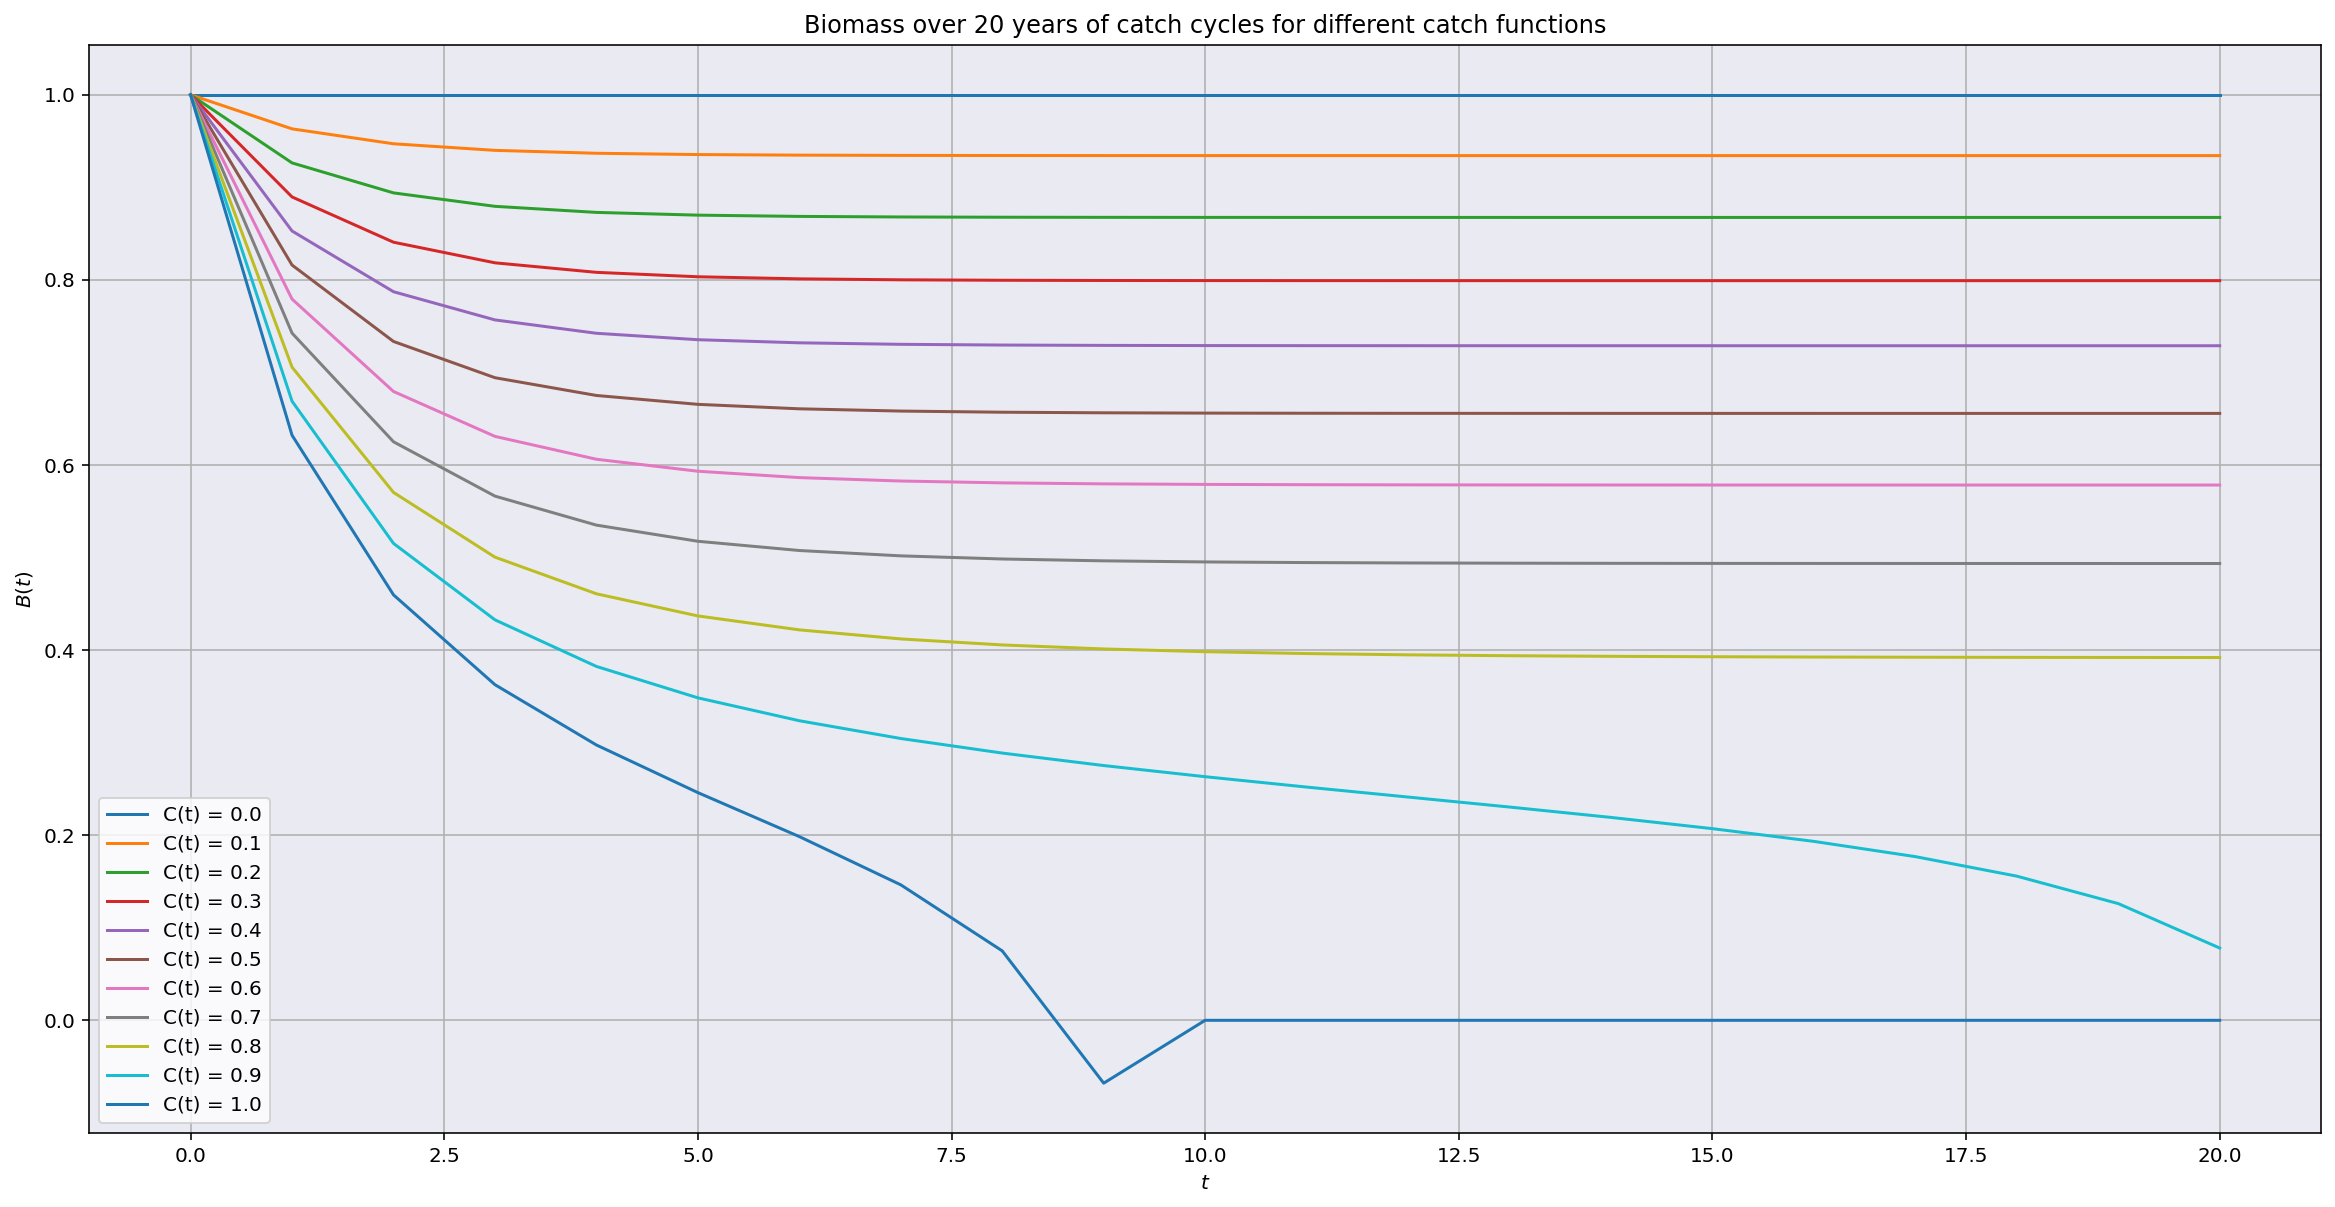

In [96]:
twenty_year_simulation(c_test, False, False)

To further examine how these systems behave, I will also generate simulations for a twenty year system with $C_t = 0$
### $C_t = 0$

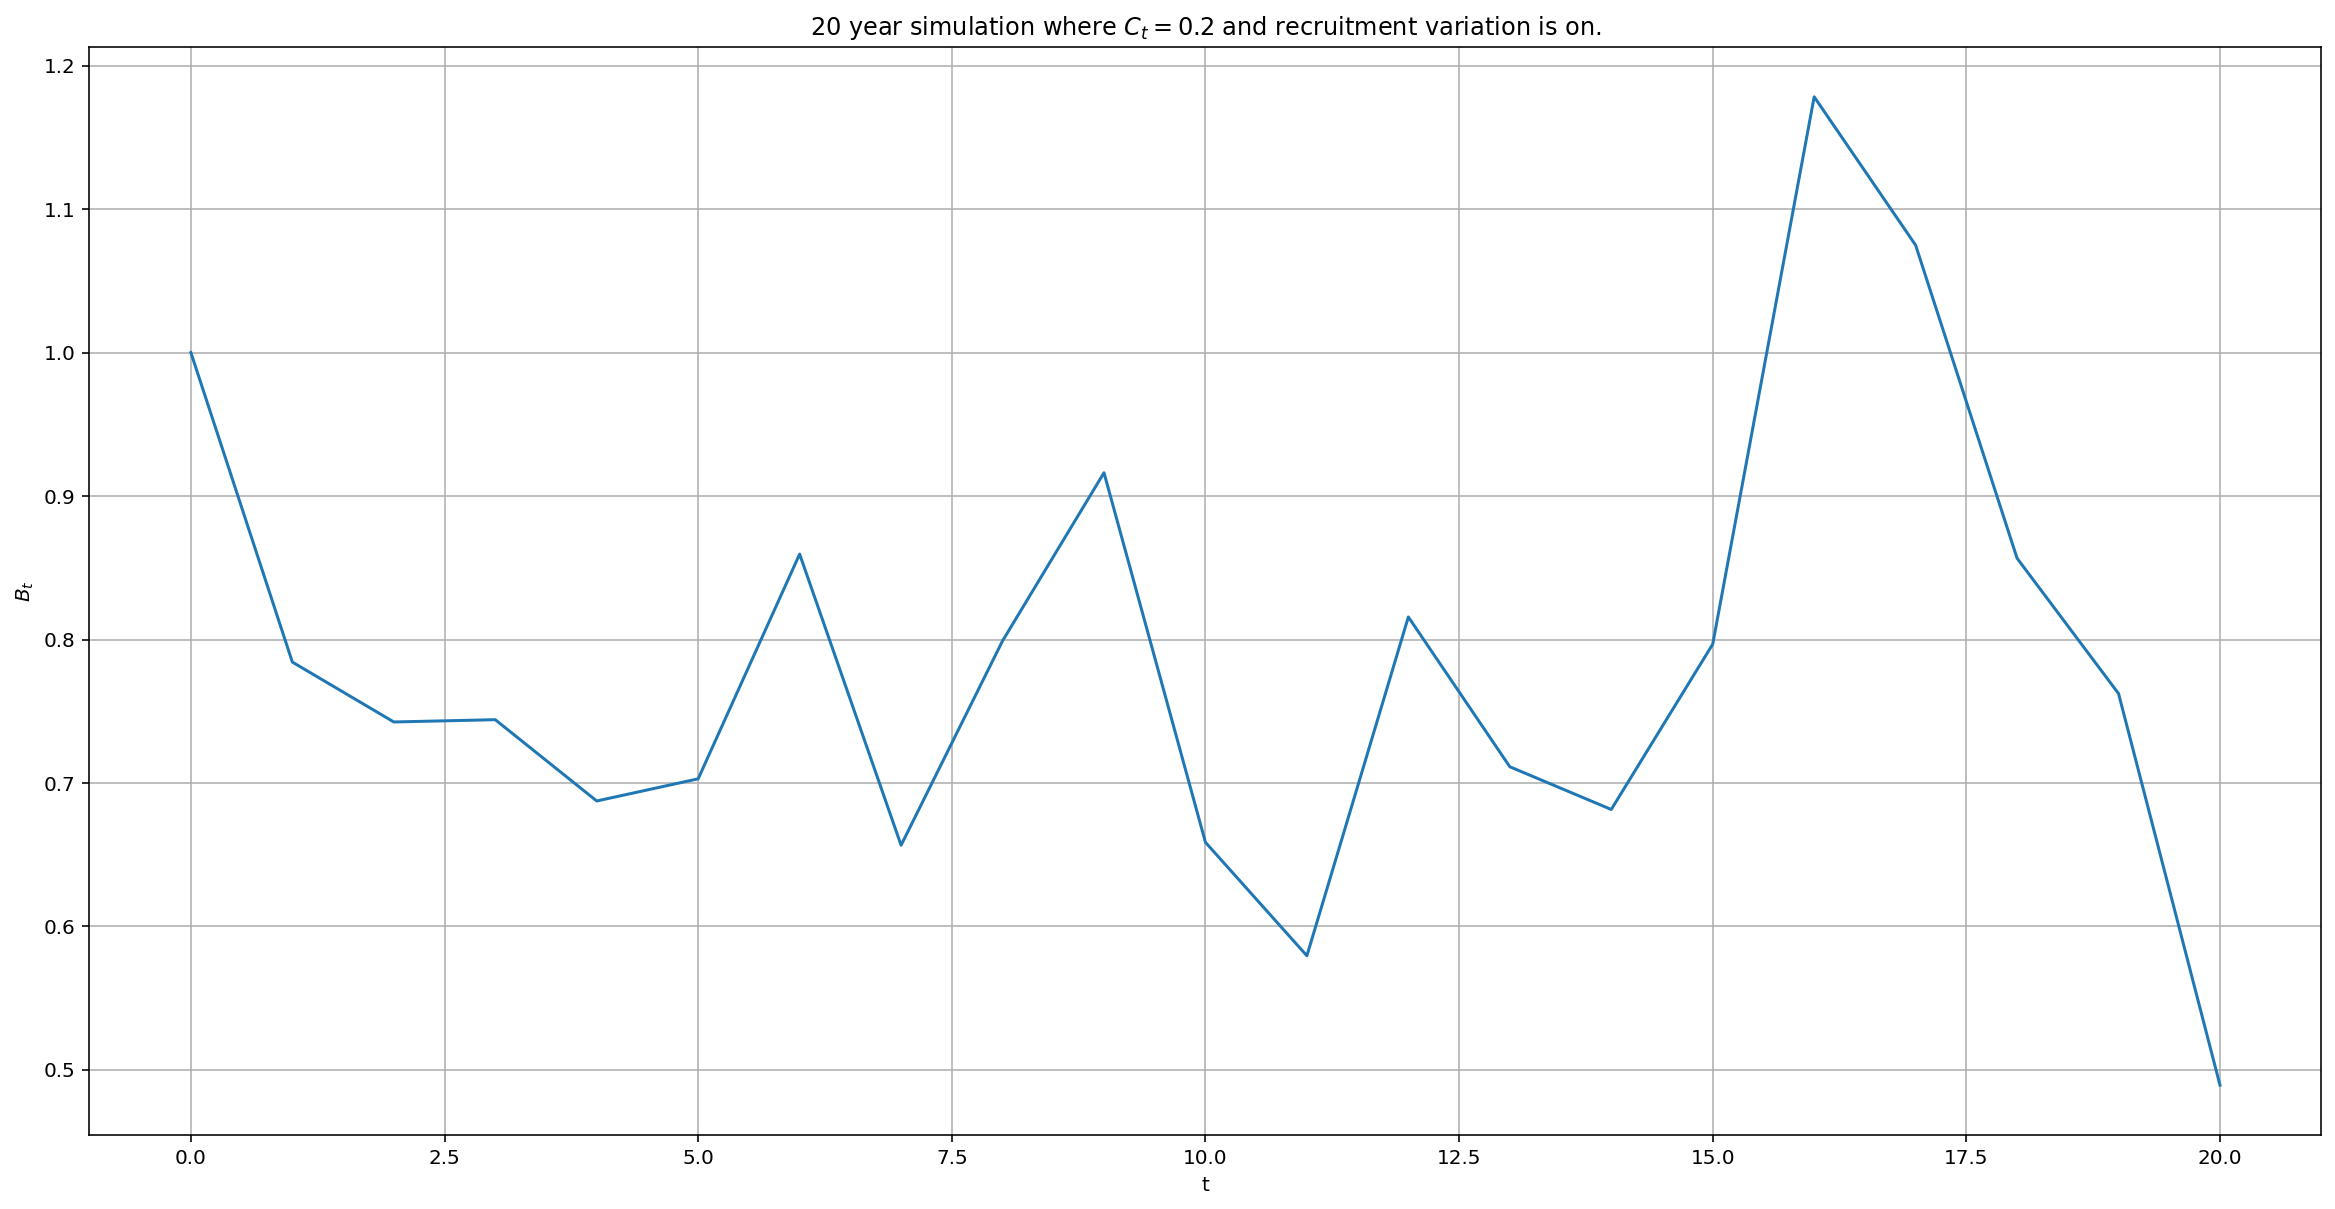

In [12]:
y = squidcycle(0.2, True, False)
plt.figure(figsize = (20,10))
plt.title(r"20 year simulation where $C_t = 0.2$ and recruitment variation is on.")
plt.ylabel(r"$B_t$")
plt.xlabel("t")
plt.plot(t, y)
plt.grid()

## First Result Comparison
If I understand correctly this is what is required for monday:
 - Show a 20 year trajectory of catch function $c = 0.2$ and record $B_{20}$ with no random variation.
 - Show a 20 year trajectory of catch function $c = 0.2$ and record $B_{20}$ with random variation in recruitment.
 - Generate 100 (or more) $c = 0.2$ trajectories with random variation in recruitment [and observation error?]
     - plot a histogram of all $B_{20}$ results
     - calculate the mean, and standard deviation of $B_{20}$ results
     - calculate the $SEM = \frac{\sigma}{\sqrt{n}}$


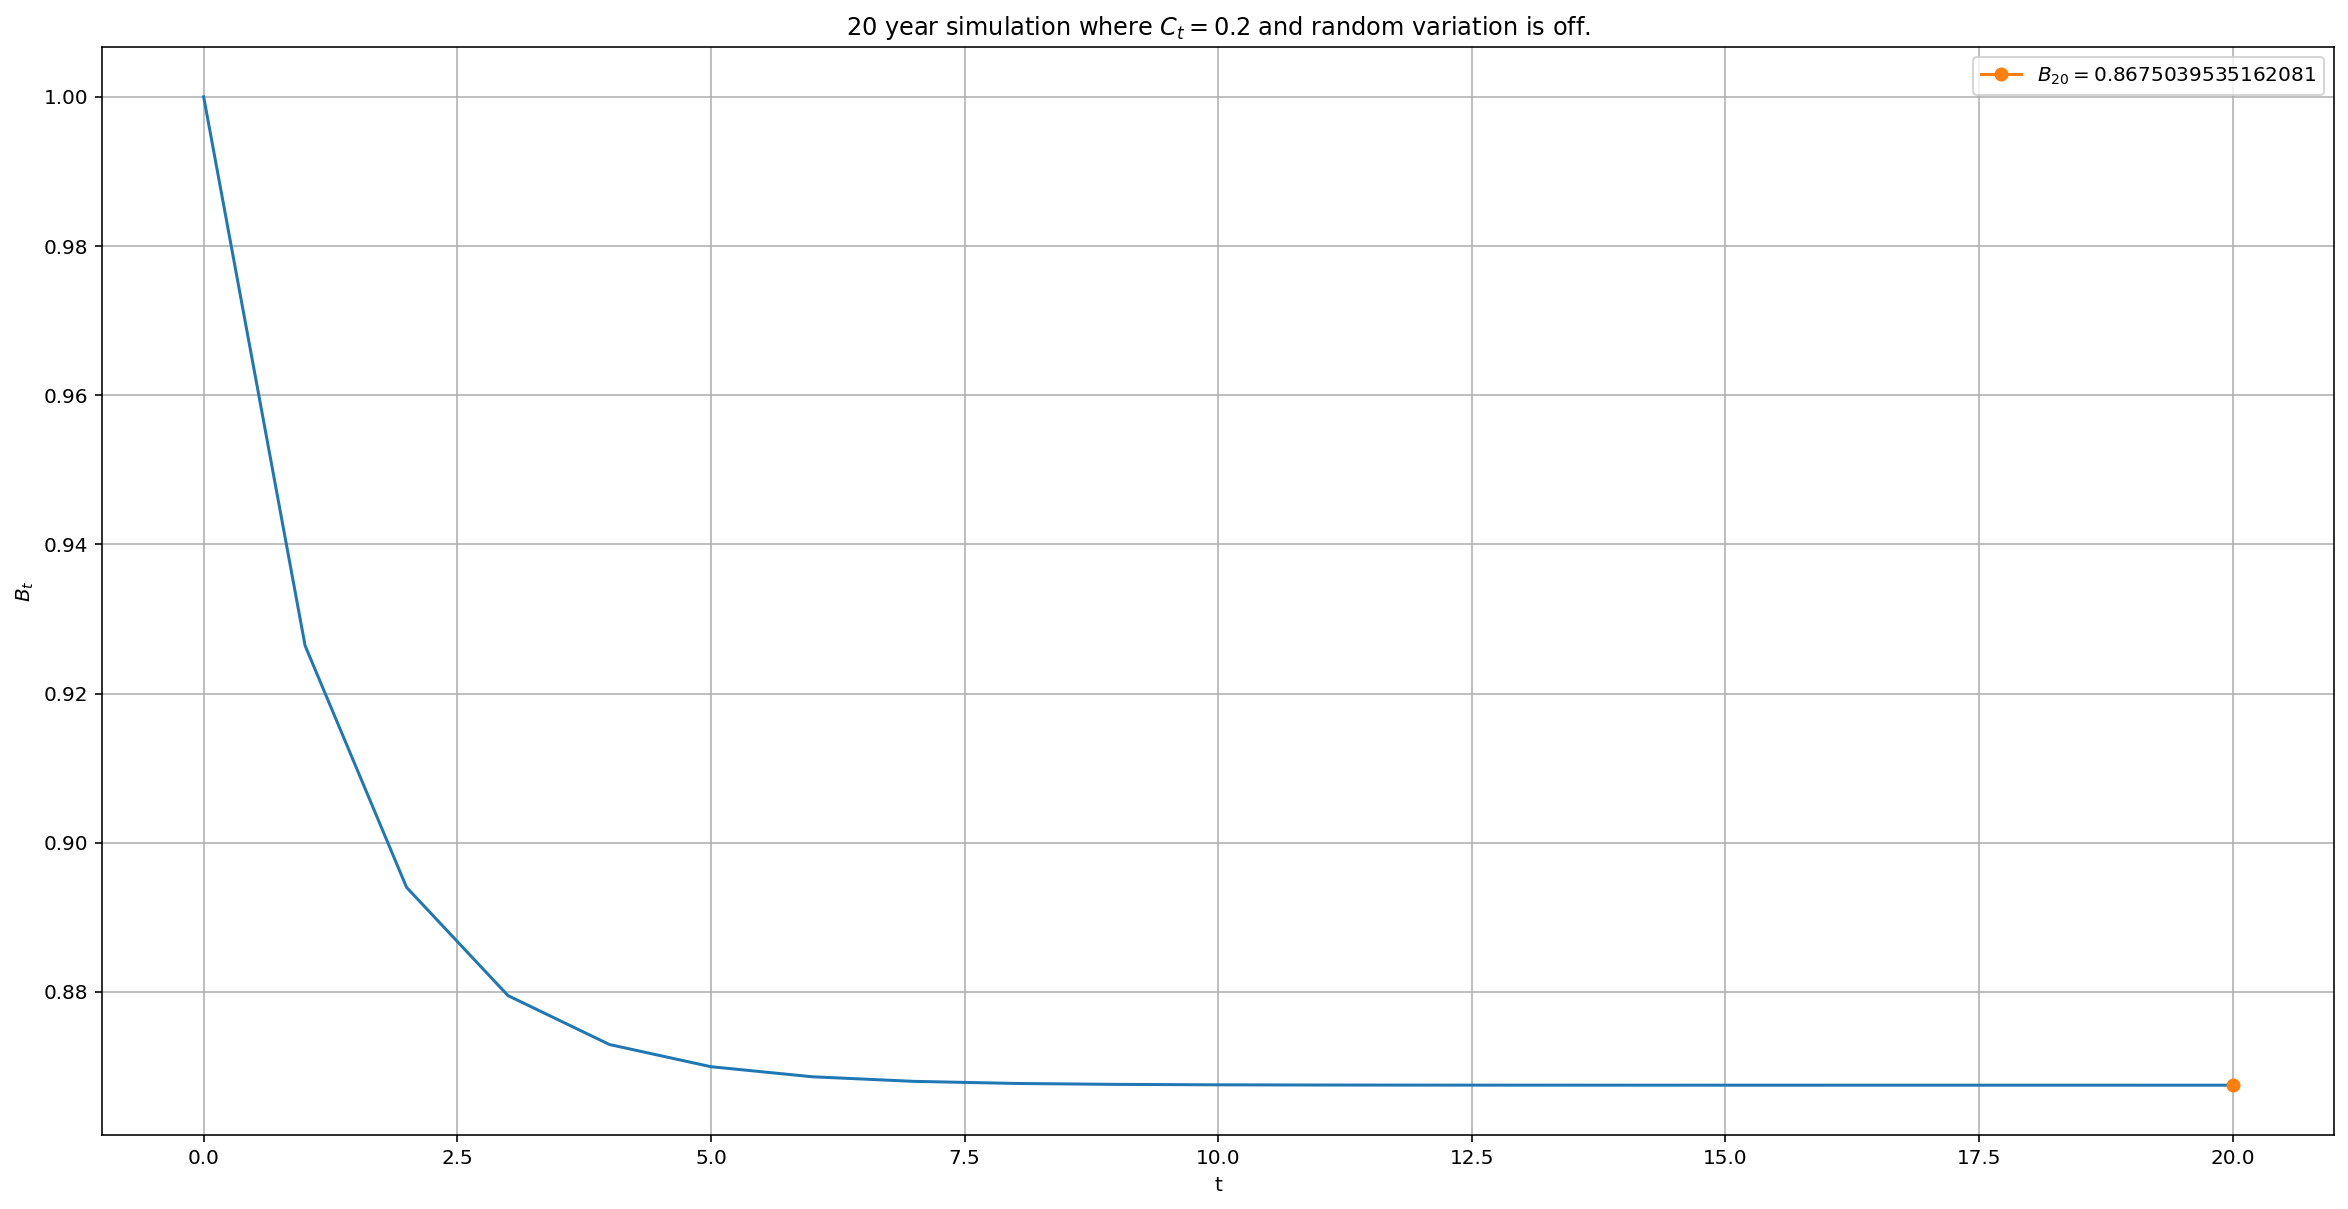

In [13]:
y = squidcycle(0.2, False, False)
plt.figure(figsize = (20, 10))
plt.title(r"20 year simulation where $C_t = 0.2$ and random variation is off.")
plt.ylabel(r"$B_t$")
plt.xlabel("t")
plt.plot(t, y)
plt.plot(t[-1], y[-1],marker = 'o', label = r"$B_{20}=$"+str(y[-1]))
plt.legend()
plt.grid()
plt.savefig("figure1.png")

### 100+ trajectories

In [14]:

b_ends = []
n = 1000000
for i in range(0, n, 1):
    simulation_masses= squidcycle(0.2, True, False)
    b_ends.append(simulation_masses[-1])

mean = np.mean(b_ends)
std = np.std(b_ends)
SME = std / np.sqrt(n)
print(mean)
print(std)
print(SME)

0.8600689252758495
0.21243475742343912
0.0002124347574234391


<ipython-input-15-154b773f6b1c>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


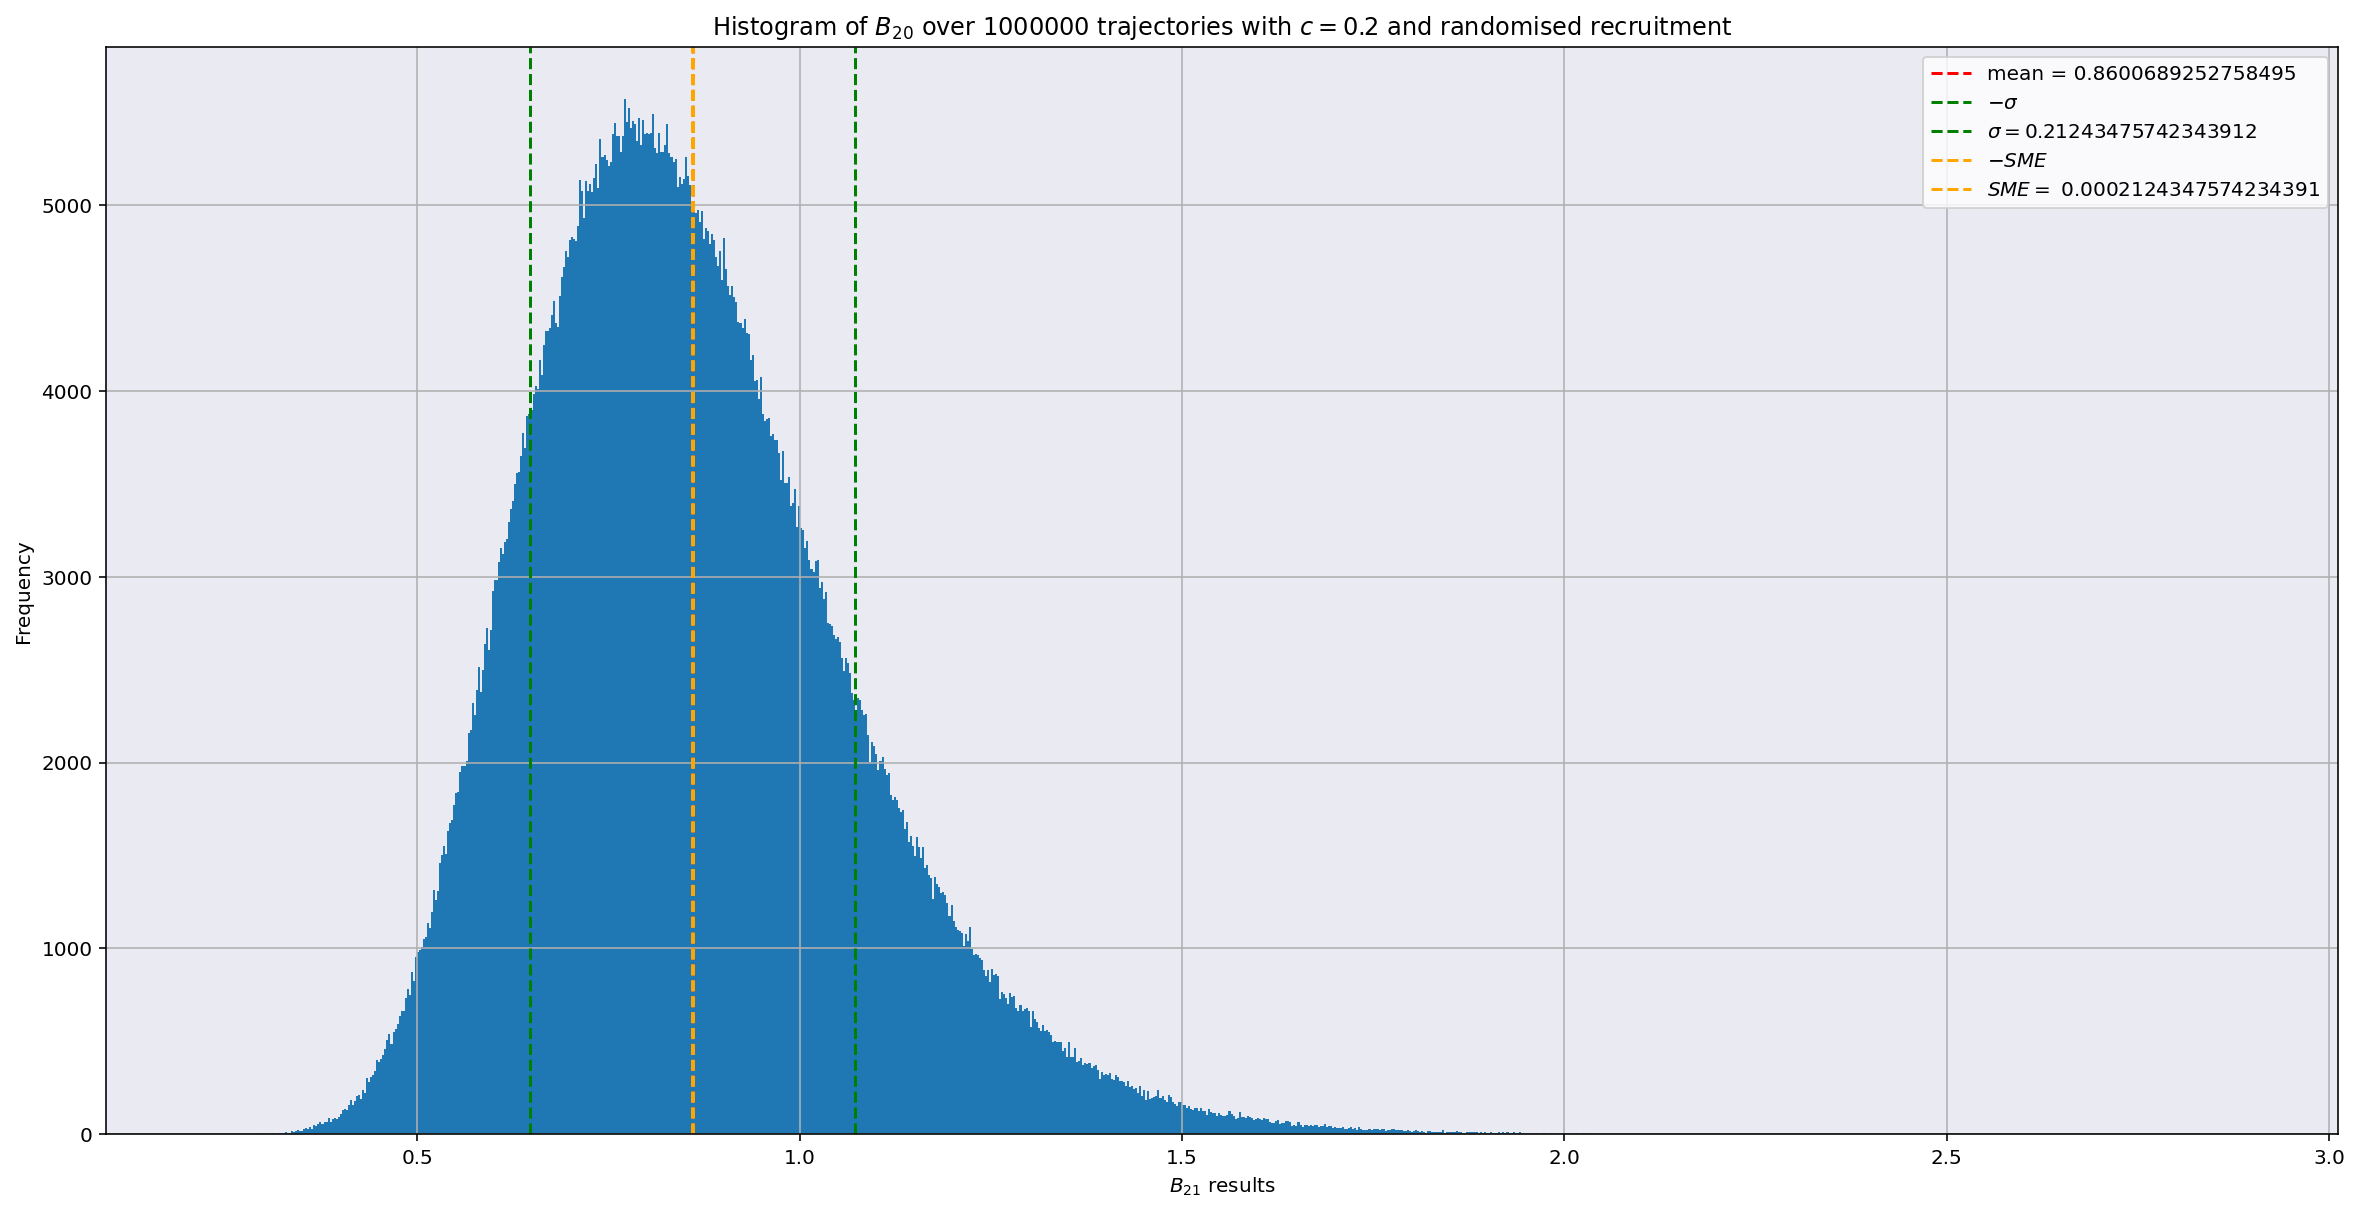

In [15]:
plt.figure(figsize = (20, 10))
plt.title(r"Histogram of $B_{20}$ over " + str(n) + " trajectories with $c = 0.2$ and randomised recruitment")
plt.ylabel("Frequency")
plt.xlabel(r"$B_{21}$ results")
plt.hist(b_ends, bins = 1000)
plt.axvline(x=mean, color='red', linestyle='--', label = "mean = "+str(mean))
plt.axvline(x=mean+std, color='green', linestyle='--', label = r"$-\sigma$")
plt.axvline(x=mean-std, color='green', linestyle='--', label = r"$\sigma = $"+str(std))
plt.axvline(x=mean+SME, color='orange', linestyle='--', label = r"$-SME$")
plt.axvline(x=mean-SME, color='orange', linestyle='--', label = r"$SME =$ "+str(SME))

plt.legend()
ax = plt.axes()
  
ax.set_facecolor('#eaeaf2')
plt.grid()
plt.savefig("histogram_n"+str(n)+".jpeg")

## Custom Catch Functions
Here I am going to start introducing my own catch functions and setting up the methods to do all the analysis I need to assess their effectiveness.

### Feedback loop
This is a simple metod that will either try catch more or less based on the previous measurement of $B_{obs}$ by some reactivity parameter $\alpha$

In [18]:
def catch(C,sensitivity, Bobs, i):
    if Bobs[i] !=0:
        if (i<1): # or (Bobs[-1]==Bobs[-2]):
            c = C
            
        if (i>=1) and (Bobs[i] < Bobs[i-1]):
            if (i>2):
                rollsum = sum(Bobs[i-3:i])
            else:
                rollsum = 3*Bobs[i]
                avg = rollsum/3
            c = (C - sensitivity)#*(avg)
        
        if (i>=1) and (Bobs[i] >= Bobs[i-1]):
            if (i>2):
                rollsum = sum(Bobs[i-3:i])
            else:
                rollsum = 3*Bobs[i]
                avg = rollsum/3
            c = (C + sensitivity)#*(avg+1)
    
        if(c<=0):
            c = sensitivity
    else:c = 0
    return c


In [19]:
def newsquidcycle(ci, sensitivity, recruit_toggle, obs_toggle):
    """
    squid cycle takes an initial biomass, and the other parameters detailed below, and runs a 20 year simulation
    whereby the squid have a recruitment period, have a catching season, and remain to be hunted by it's natural preditors
    until the next recruitment period.
    
    Bi is the initial biomass.
    sigR is the standard deviation for the normal distribution that takes the variation in recruitment into account.
    sigS is the standard deviation for the normal distribution that takes the error in survey observation into account.
    K is the Carrying Capacity of the system.
    be is beta.
    al is alpha
    M is the mortality rate of the squid due to natural processes.
    C is the catch function.
    recruit_toggle toggles the presense of random variation in the recruitment.
    obs_toggle toggles the presense of random error of observation.
    
    The function returns an array of the biomass at each time step.
    """
    #Inital Conditions
    Bi = 1
    K = 1
    sigR = 0.3
    sigS = 0.2
    h = 0.7
    be = (0.2*K*(1-h)) / (h - 0.2)
    M = 1
    al = (K+be)*( (np.e**M)-1 )
    #print(be)
    #print(al)
    #Simulation Setup
    Barr = np.zeros(len(t))
    catches = np.zeros(len(t))
    C=ci
    Rarr = []
    #Alternate implimentations based on whether we want random effects. This part applies to the first observation
    if obs_toggle == True:
        Bobs = Bi*np.e**( (nt(sigS) - sigS**2)/2 )
    else:
        Bobs = Bi
        
    #Barr[0] = Bobs
   # C = catch(ci, sensitivity, [Bobs], 0)
    for i in range(0, len(t)):
        
        Barr[i] = Bobs
        C = catch(C, sensitivity, Barr, i)
        catches[i] = C
        if Barr[i] <=0: #This stops the simulation from running if the population has dropped to (or below) zero. The species is extinct.
            Barr[i] = 0 #we set any negative values to zero
            break
        else:
            tmpy = Bobs
            R = Ru(tmpy, al, be, sigR, recruit_toggle)
            Rarr.append(R)
            Bobs = (tmpy + R - C) * np.e**(-M)
            if obs_toggle == True:
                Bobs = Bobs*np.e**( (nt(sigS) - sigS**2)/2 ) #Adds random variation to the observation.
        
            
    return Barr, catches, Rarr

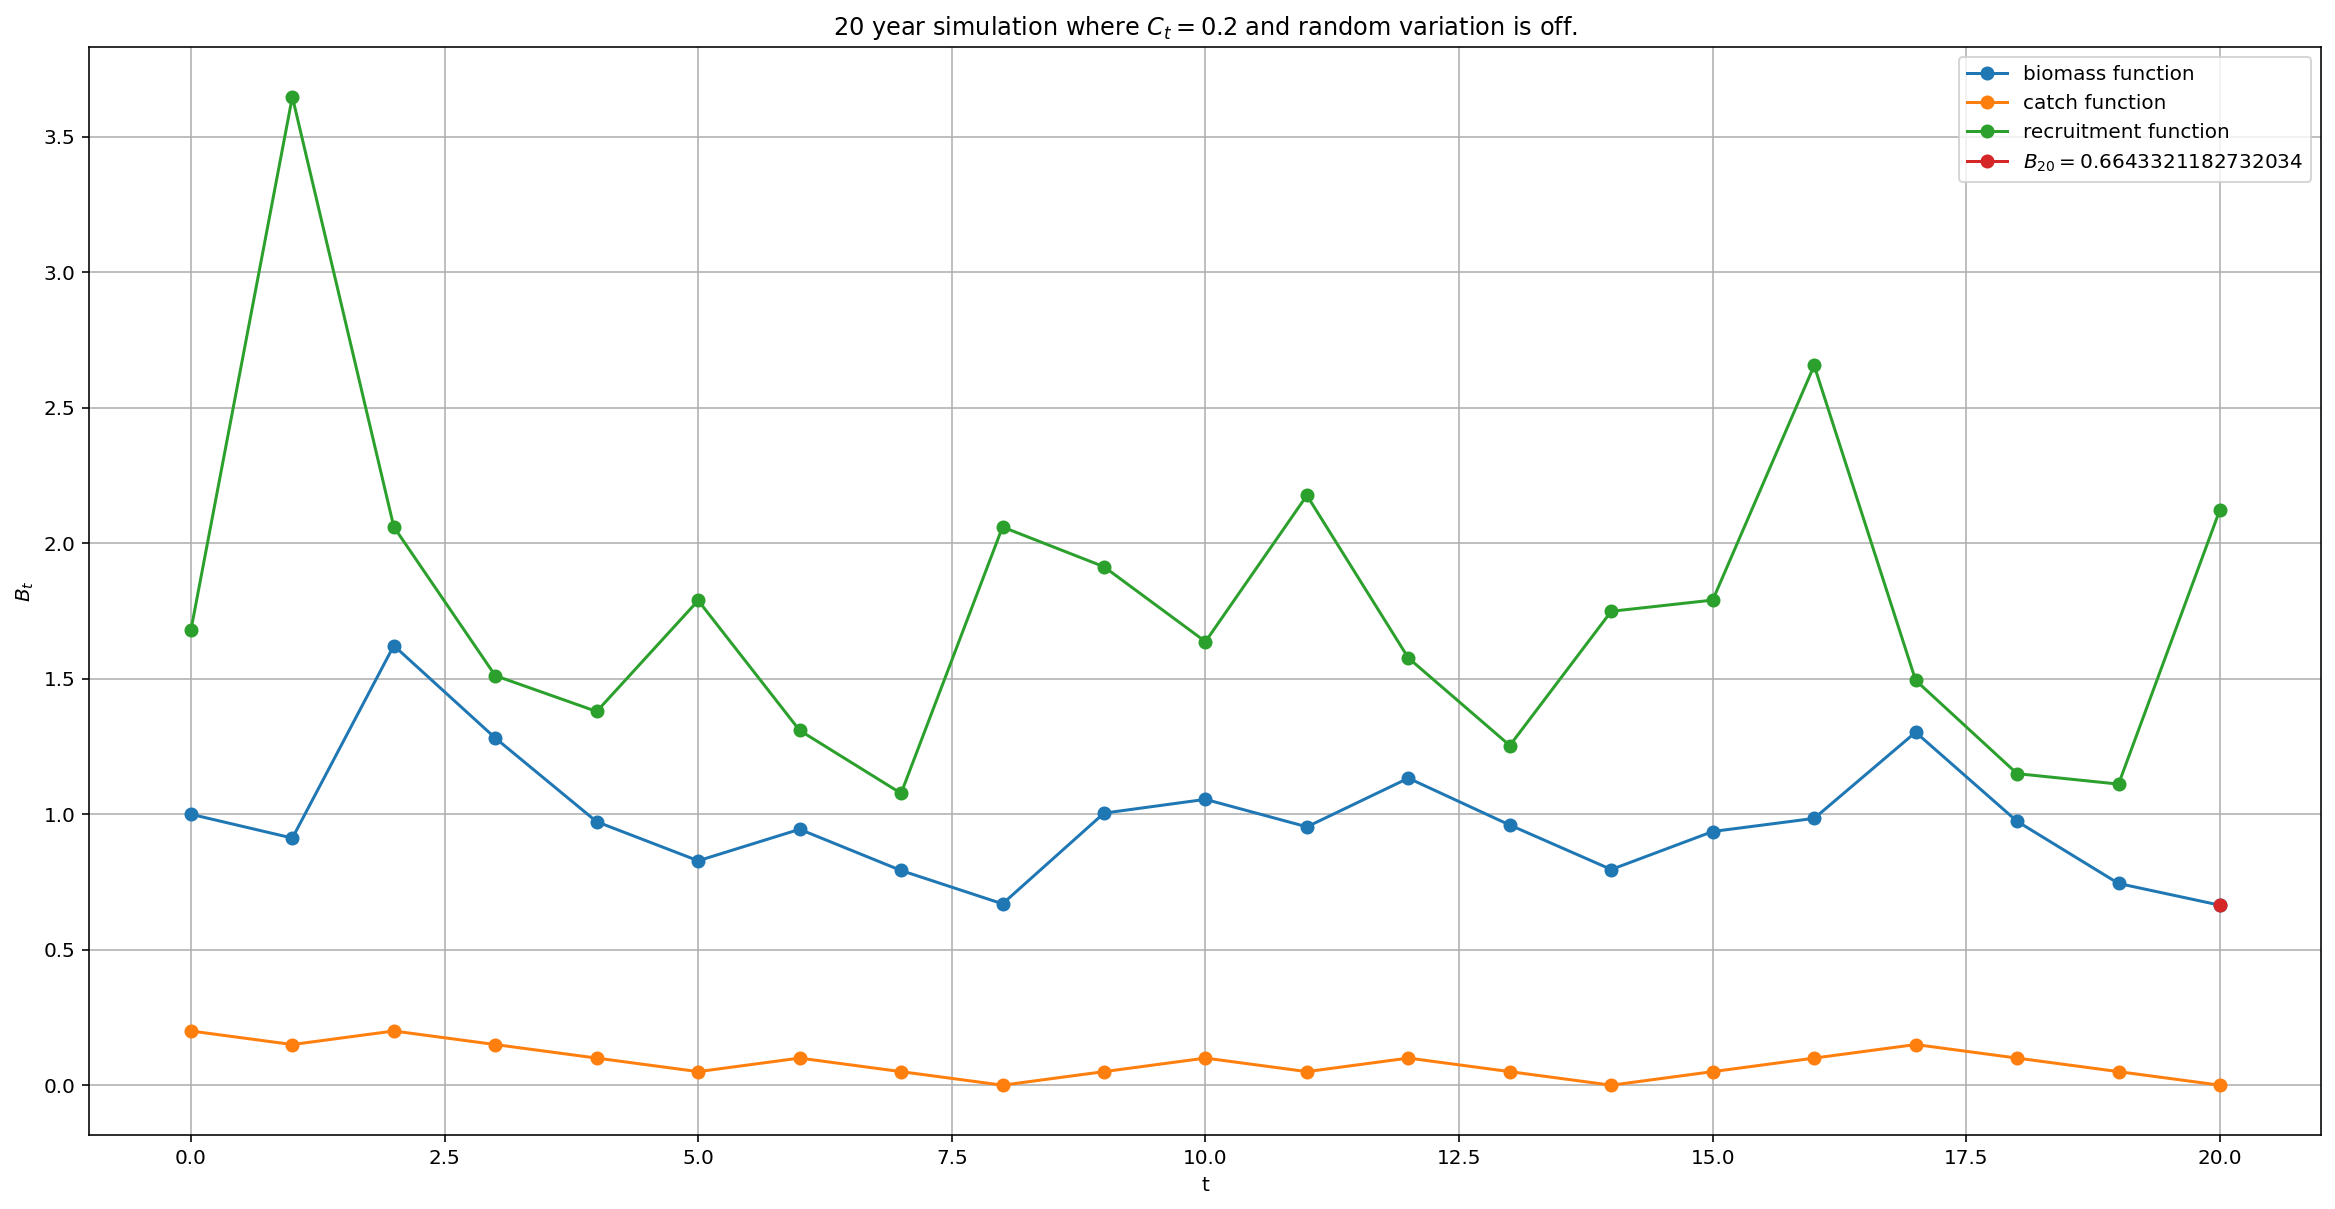

In [20]:
y,c,r = newsquidcycle(0.2, 0.05, True, False)

plt.figure(figsize = (20, 10))
plt.title(r"20 year simulation where $C_t = 0.2$ and random variation is off.")
plt.ylabel(r"$B_t$")
plt.xlabel("t")
plt.plot(t, y, marker = 'o', linestyle = '-', label = 'biomass function')
plt.plot(t, c, marker = 'o', linestyle = '-', label = 'catch function')
plt.plot(t, r, marker = 'o', linestyle = '-', label = 'recruitment function')
plt.plot(t[-1], y[-1],marker = 'o', label = r"$B_{20}=$"+str(y[-1]))
plt.legend()
plt.grid()
#plt.savefig("figure1.png")

In [21]:
print(c)

[2.00000000e-01 1.50000000e-01 2.00000000e-01 1.50000000e-01
 1.00000000e-01 5.00000000e-02 1.00000000e-01 5.00000000e-02
 1.38777878e-17 5.00000000e-02 1.00000000e-01 5.00000000e-02
 1.00000000e-01 5.00000000e-02 1.38777878e-17 5.00000000e-02
 1.00000000e-01 1.50000000e-01 1.00000000e-01 5.00000000e-02
 1.38777878e-17]


In [22]:
def catchtest(sims, catches):
    """The purpose of this function is to assess the overall performance of the catch function.
    I will use the benchmarks given to us to measure.
    The required metrics are:
    - Highest Possible Catch
    - Lowest Variation of year-on-year yeild
    - Lowest Probability of wiping out the resourse."""
    #Metric 1
    means = []
    
    for i in range(len(catches)):
        means.append(stats.mean(catches[i]))
    catch_median = stats.median(means)
    #print(means)
    #Metric 2
    YoY_change = []
    for i in range(len(sims)):
        tmp = []
        for j in range(1, len(catches[i]), 1):
            if catches[i][j] == 0:
                percent_change = 0
            else:
                percent_change = abs(catches[i][j] - catches[i][j-1])/catches[i][j-1]
            tmp.append(percent_change)
        #print()
        YoY_change.append(stats.mean(tmp))
    variation_median = stats.median(YoY_change)
    #print(YoY_change)
    #Metric 3
    final_biomass = []
    for i in range(0, len(sims), 1):
        final_biomass.append(sims[i][-1])
    final_biomass.sort()
    lower_fifth_percentile = final_biomass[499] #50th entry of 1000 simulations
    #print(final_biomass)
    #Metric 4
    lowest_biomass = []
    for i in range(0, len(sims), 1):
        lowest_biomass.append(min(sims[i]))
    lb_median = stats.median(lowest_biomass)
    #print(lowest_biomass)
    #print(lb_median)
    return catch_median,variation_median,lower_fifth_percentile,lb_median

In [115]:
N = 10000
sims = []
catches = []
for i in range(0, N, 1):
    b,c,r = newsquidcycle(0.8, 0.0, True,True)
    sims.append(b)
    catches.append(c)
array = catchtest(sims,catches)
#s = (array[0]*array[3])/(array[1]*array[2])
s = np.e**(array[0]+array[2]+array[3]-array[1])
print(array)
print(s)

(0.5714285714285715, 0.0, 0.0, 0.0)
1.770794952435155


In [112]:
cumulative_catches = []
for i in range(0, len(catches), 1):
    cumulative_catches.append(sum(catches[i]))
avg = 0
cumulative_catches.sort()
for i in range(0, len(cumulative_catches), 1):
    avg += cumulative_catches[i]
avg = avg/N
median = stats.median(cumulative_catches)
print(avg)
print(median)

10.987070000000118
11.0


In [116]:
def parameter_assessment(N, ci, si):
    sims = []
    catches = []
    for i in range(0, N, 1):
        b,c,r = newsquidcycle(ci, si, True,True)
        sims.append(b)
        catches.append(c)
    catch_tests = catchtest(sims,catches)
    score = np.e**(catch_tests[0]+catch_tests[2]+catch_tests[3]-catch_tests[1])
    return score

In [117]:
def parameter_sweeper(N):
    """The purpose of this function is to sweep over different parameters of initial catch functions and sensitivity."""
    Carr = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    
    Sarr = [0,0.05, 0.075, 0.10, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]
    
    scores = []
    for i in range(0 , len(Carr), 1):
        score_columns = []
        for j in range(0, len(Sarr), 1):
            score_columns.append(parameter_assessment(1000, Carr[i], 0))
            #print(score_columns)
            #print()
        scores.append(score_columns)
        #print(i)
    return scores

In [118]:
scores = parameter_sweeper(1000)

In [119]:
print(len(scores[1]))

10


In [120]:
Carr = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]


In [121]:
import seaborn as sns
Sarr = [0,0.05, 0.075, 0.10, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]
df_scores = pd.DataFrame(scores, columns = Sarr )
df_scores['Ci'] = Carr
df_scores = df_scores.set_index(df_scores['Ci'])
df_scores = df_scores.drop('Ci', axis = 1)
display(df_scores)

,0.000,0.050,0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250
Ci,,,,,,,,,,
0.05,4.749840,4.734691,4.772364,4.634005,4.750626,4.728299,4.670109,4.747347,4.804570,4.823894
0.10,4.669102,4.678499,4.627467,4.736035,4.672407,4.719653,4.674607,4.664760,4.673685,4.713652
0.15,4.706051,4.716088,4.594919,4.617608,4.667389,4.643963,4.670101,4.514597,4.631373,4.632818
0.20,4.609573,4.578135,4.575173,4.573246,4.581714,4.507751,4.568516,4.581906,4.519387,4.587797
0.25,4.452334,4.524484,4.484329,4.473964,4.500967,4.469045,4.557940,4.612028,4.530828,4.442124
0.30,4.408391,4.439567,4.433292,4.407920,4.390160,4.479206,4.402606,4.405701,4.391441,4.405274
0.35,4.389298,4.378059,4.381575,4.374641,4.341781,4.441538,4.335883,4.403486,4.356612,4.311511
0.40,4.238842,4.263527,4.236074,4.276545,4.280502,4.215729,4.342418,4.259160,4.299001,4.249267
0.45,4.203283,4.201539,4.210469,4.150840,4.094392,4.215569,4.166909,4.207209,4.165318,4.206179


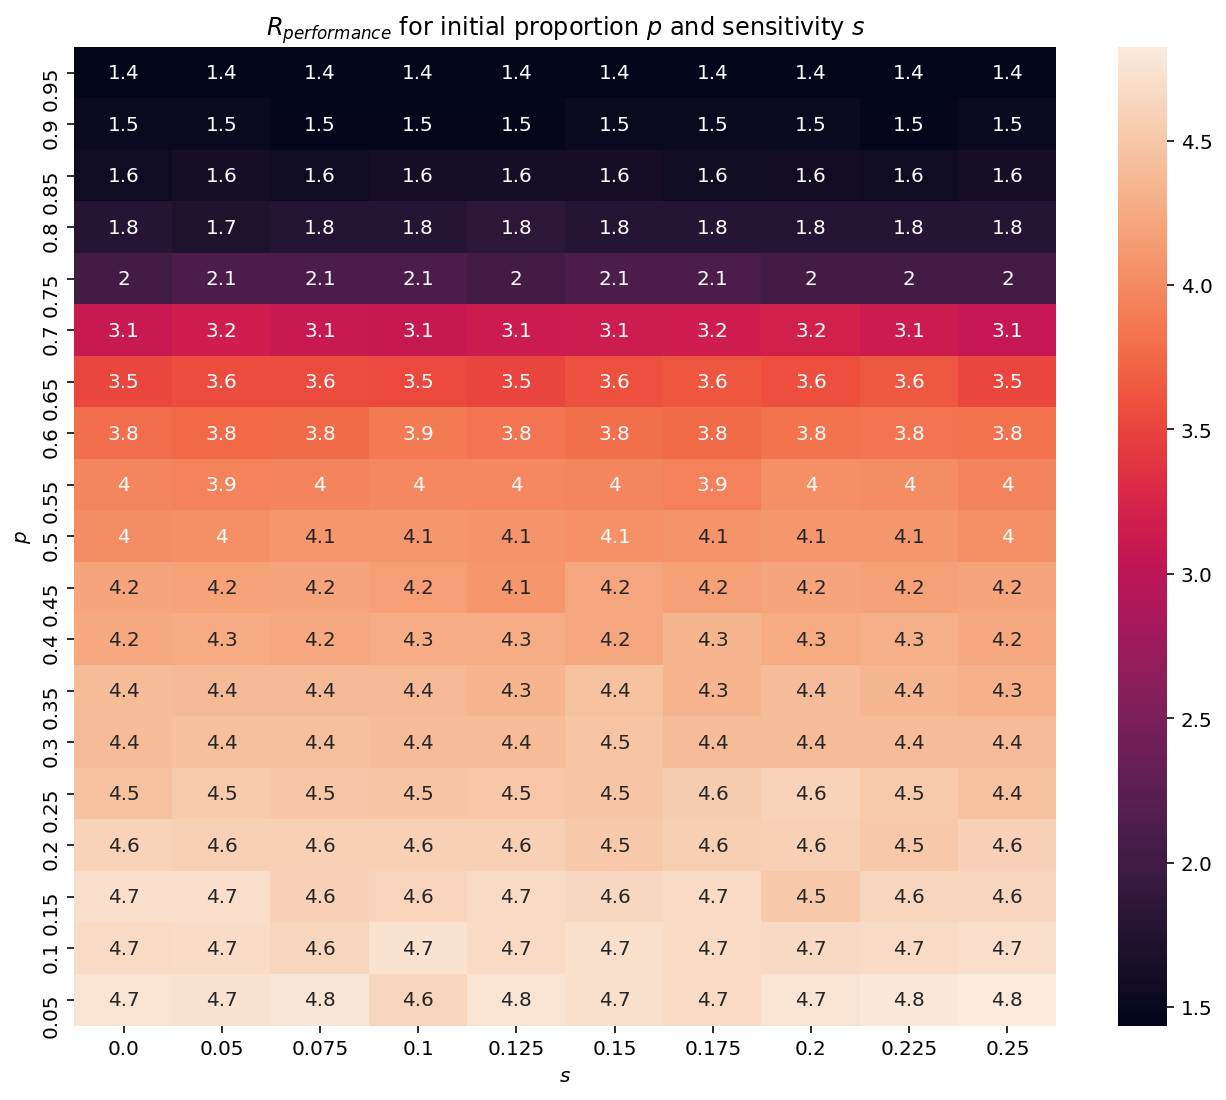

In [122]:
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_scores.reindex(index=df_scores.index[::-1]), annot = True)
plt.title(r"$R_{performance}$ for initial proportion $p$ and sensitivity $s$")
plt.xlabel(r'$s$')
plt.ylabel(r'$p$')
plt.savefig("performance_matrix.jpeg")
plt.show()


The feedback loop catch function works well at consistently attaining decent catches while limiting the stress on the resource. The simplicity of the function makes it easy to implement. 
Additionally, the range of parameters in which the function performs comparatively well forms a 'safety net' that allows for more aggressive or conservative parameters to be used.
Further models could include the cost of the yearly catch and the average pricing of the resource in order to assess profitability of the catch function.